In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised =True, with_info =True)

In [ ]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    =

In [ ]:
#ponemos cada conjunto de datos en una variable para utilizarlo
datos_entrenamiento, datos_pruebas = datos["train"], datos["test"]

In [ ]:
#los metadatos tienen las categorias que existen en el set y podemos imprimirlos con una variable
nombres_clases = metadatos.features["label"].names

In [ ]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
#normalizar los datos (pasar de 0 225 a 0-1)
#utilizamos una funcion de normalizacion para dividir cada pixel entre 255
def normalizar (imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 225 #aqui pasa de 0-255 a 0-1
  return imagenes, etiquetas

#normalizar los datos de entrenamiento y pruebas con la funcion que hicimos arriba-
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datis_pruebas = datos_pruebas.map(normalizar)

# agregar a cache (usar memoria en lugar de disco, entramiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

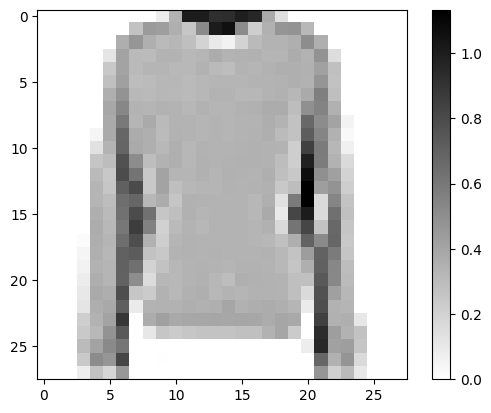

In [ ]:
# mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #redimensionar, cosas de tensores.

import matplotlib.pyplot as plt

#dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

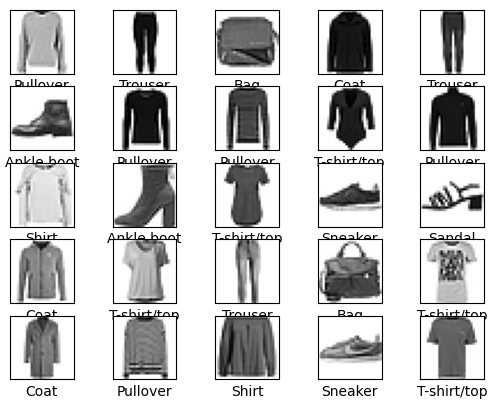

In [ ]:
# podemos imprimir varias imagenes y que nos muestre cual es la categoria correcta con la que viene etiquetada-
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [ ]:
# pasamos a hacer el modelo

modelo = tf.keras.Sequential([ #creamos una red de tipo sequencial
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
#definimos la capa de entrada manualmente y utilizamos el tipo flatten
# los datos que le vamos a dar a la red vienen en una forma de 28 pixeles con un canal que es blanco y negro
# la capa flatten se encarga de convertir la matriz y aplastarla a una sola dimension con 784 neuronas en las que se recibiran cada pixel
    # agregamos 2 capas ocultas densas con 50 neuronas cada una y cada una con la activacion rell
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    #agregamos la capa de salida con 10 neuronas
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #se usa la funcion softmax como funcion de activacion de la capa de salida en las redes de clasificacion para asegurar que las sumas de las neuronas de salida siempre nos de 1
])

In [ ]:
# ahora solo compilamos el modelo

modelo.compile(
    optimizer="adam", #usamos como en la anterior neurona adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), #usamos esta funcion de perdida
    metrics=["accuracy"]
)

In [ ]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [ ]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [ ]:
# para que la red entrene mas rapido podemos decirle a la red que entrene por lotes
TAMANO_LOTE = 32
#daremos varias vueltas al set de datos en el entrenamiento queremos que se haga de manera aleatoria y no en un orden
# vamos a usar dos funciones repeat y shuffle con las cuales el orden de los datos va a ser aleatorio
# a shuffle le diremos cuantos datos queremos utilizar

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
import math

#entrenar
#funcion de entrenamiento fit espeficicamos los datos de entrenamiento cuantas vueltas queremos que de a los datos (5) y ponemos la funcion steps per epoch pero no es relevante ya que segun tensorflow lo quita.
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch = math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 20s 4ms/step - loss: 0.5135 - accuracy: 0.8195
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3871 - accuracy: 0.8606
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3460 - accuracy: 0.8723
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3292 - accuracy: 0.8792
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3098 - accuracy: 0.8860


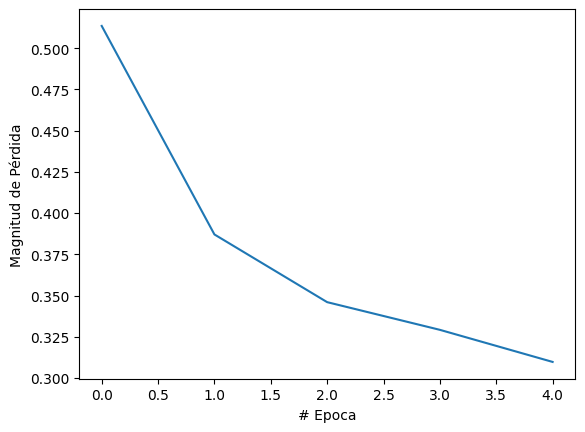

In [ ]:
# idealmente tenemos que quedar con un % del 88 o mayor.

plt.xlabel("# Epoca")
plt.ylabel("Magnitud de Pérdida")
plt.plot(historial.history["loss"])


1/1 [==============================] - 0s 98ms/step


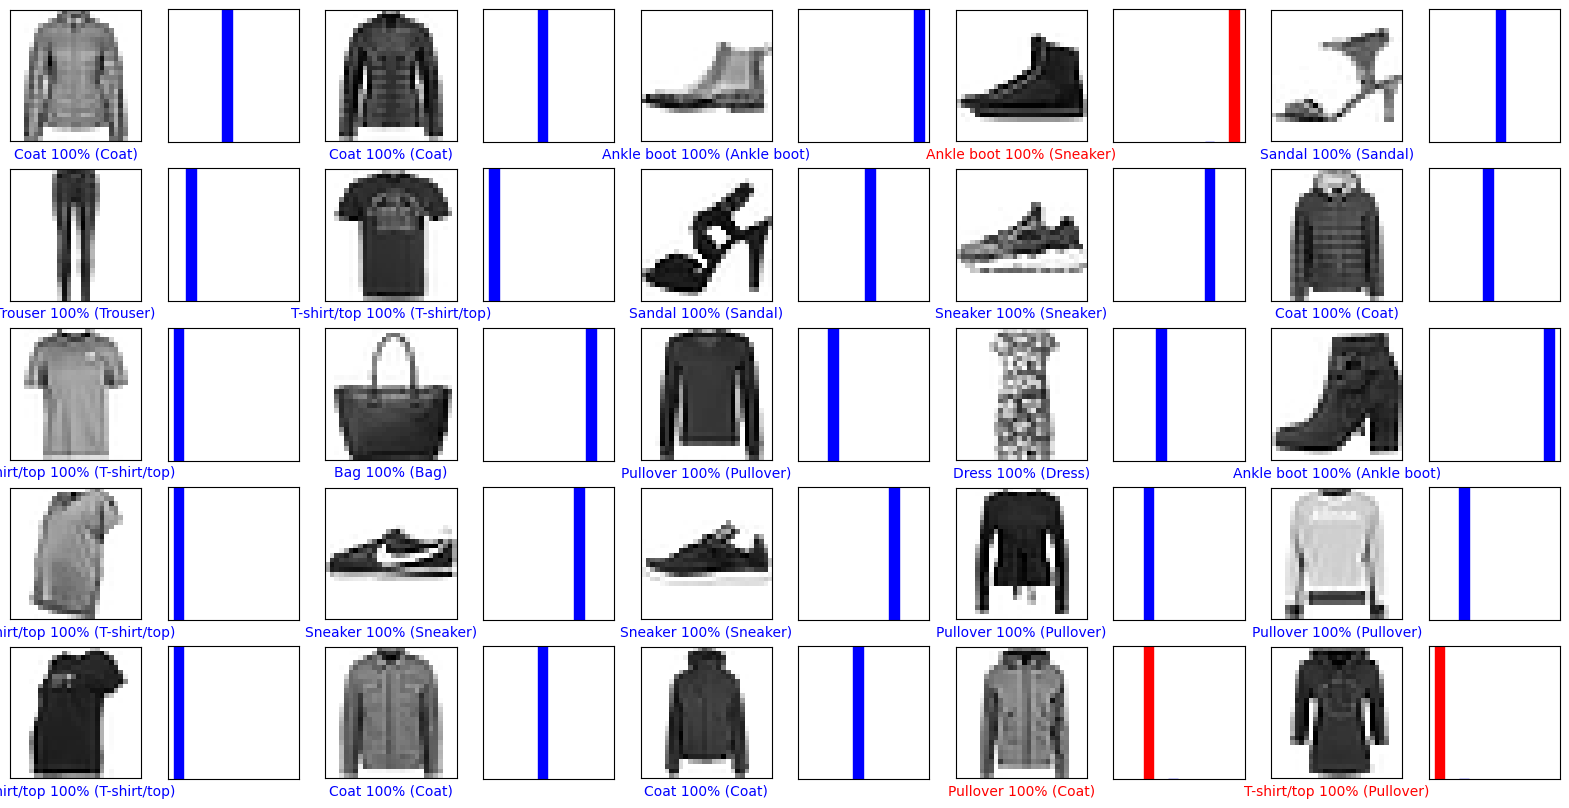

In [ ]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [ ]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 66ms/step
Prediccion: Sandal


In [ ]:
#Exportacion del modelo a h5
modelo.save('modelo_exportado.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 54.1 MB/s eta 0:00:00


In [ ]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

2024-02-25 00:05:39.270049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 00:05:39.270128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 00:05:39.272462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 00:05:41.116116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
#Veamos si si creo la carpeta
!ls

modelo_exportado.h5  sample_data  tfjs_target_dir


In [ ]:
#Vemos el contenido de la carpeta
!ls tfjs_target_dir

group1-shard1of1.bin  model.json
